In [16]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
from gui.output_utils import *

def get_exp_ids_for_varying_k(corpus='amazon_grouped-tagged'):
    # curve when varying k
    query_dict = {'allow_overlap': 0,
                  'decode_handler': 'SignifiedOnlyFeatureHandler',
                 'document_features_ev': 'AN+NN',
                 'document_features_tr': 'J+N+AN+NN',
                 'k__in': [1,3,5],
                 'labelled': 'amazon_grouped-tagged',
                 'neighbour_strategy': 'linear',
                 'noise': 0.0,
                 'use_random_neighbours': 0,
                 'use_similarity': 0,
                'vectors__composer__in': ['Add', 'Mult', 'Left', 'Right'], # todo Verb???
                'vectors__algorithm': 'word2vec',
                 'vectors__dimensionality': 100,
                 'vectors__rep': 0,
                 'vectors__unlabelled': 'wiki',
                 'vectors__unlabelled_percentage': 100,
                 'vectors__use_ppmi': 0                  
}
    return Experiment.objects.filter(**query_dict)#.values_list('id', flat=True)

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


ids are [34, 35, 36, 37, 38, 39, 40, 41, 97, 107, 117, 127]


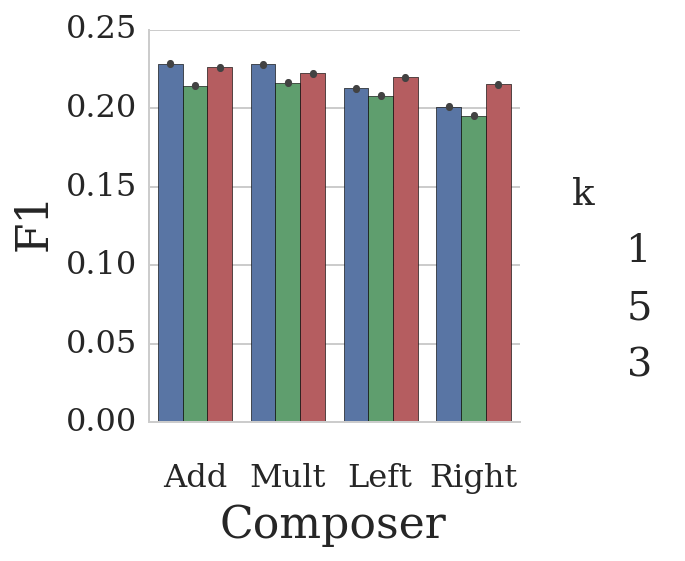

In [21]:
experiments = get_exp_ids_for_varying_k()
ids = [e.id for e in experiments if e.entries_of is None]
print('ids are', ids)
scores, folds = get_cv_scores_many_experiment(ids)
ks = np.repeat([Experiment.objects.get(id=foo).k for foo in ids],
               get_cv_fold_count(ids))
df = pd.DataFrame({'F1': scores,
                   'k': ks,
                   'cvfold': folds,
                   'Composer': get_vectors_field(ids, 'composer')})
grid = sns.factorplot(hue='k', y='F1', data=df, x='Composer',
                      kind='bar');
plt.savefig('plot-w2v_effect-of-k.pdf', format='pdf', dpi=300)